In [1]:
from machinelearning.mlpipeline import MLPipelines
from machinelearning.featexpl import FeaturesExplanation

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import optuna
import pandas as pd

from lightgbm import LGBMClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from catboost import CatBoostClassifier
# from sklearn.preprocessing import LabelEncoder ###
# from sklearn.cross_decomposition import PLSRegression

# model = LogisticRegression()
# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1],
#     'penalty': ['l1', 'l2']
# }
csv_dir = 'data/composite_dataset.csv'
label = 'group'

model = LogisticRegression()
# model = RandomForestClassifier()
# param_grid = {
#     'n_estimators': [10, 20, 50],
#     'max_depth': [None, 5, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

%load_ext autoreload
%autoreload 2

# mlpipe = MLPipelines(estimator=model, param_grid=param_grid, label=label, csv_dir=csv_dir)
# mlpipe.normalize()

In [2]:
# dataloader
mlpipe = MLPipelines(label=label, csv_dir=csv_dir, estimator=model)
# mlpipe._encode_labels()
mlpipe.normalize()
mlpipe.feature_selection(method='mrmr', n_features=10, inner_method='chi2')

Label mapping: {0: 'Factor1:CASE', 1: 'Factor1:CONTROL'}


100%|██████████| 10/10 [00:00<00:00, 19.20it/s]


In [3]:
mlpipe.bayesian_search(set_sampler='RandomSampler', n_trials=100)

[I 2024-02-05 19:23:14,043] A new study created in memory with name: no-name-78fdca33-bc65-484d-8b69-8fbe3861e089
[I 2024-02-05 19:23:14,131] Trial 0 finished with value: 0.9732050807568878 and parameters: {'penalty': 'none', 'C': 3.779988559207595, 'solver_3': 'newton-cholesky', 'max_iter': 927, 'fit_intercept': True}. Best is trial 0 with value: 0.9732050807568878.
[I 2024-02-05 19:23:14,246] Trial 1 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 9.609922528118357, 'solver_2': 'saga', 'max_iter': 644, 'fit_intercept': True}. Best is trial 1 with value: 1.0.
[I 2024-02-05 19:23:14,360] Trial 2 finished with value: 1.0 and parameters: {'penalty': 'none', 'C': 2.251631725287514, 'solver_3': 'sag', 'max_iter': 595, 'fit_intercept': True}. Best is trial 1 with value: 1.0.
[I 2024-02-05 19:23:14,457] Trial 3 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 4.1696710028467905, 'solver_2': 'newton-cg', 'max_iter': 250, 'fit_intercept': False}. Best is trial 1 

For the LogisticRegression model: 
Best parameters: {'penalty': 'l2', 'C': 9.609922528118357, 'solver_2': 'saga', 'max_iter': 644, 'fit_intercept': True}
Best matthews_corrcoef: 1.0


In [4]:
# scores, params = mlpipe.nested_cross_validation(n_trials=5,optimizer='bayesian_search')

In [ ]:
# mlpipe.bayesian_search()
# xg = [GradientBoostingClassifier(), LinearDiscriminantAnalysis(),  GaussianNB(), KNeighborsClassifier(), DecisionTreeClassifier(), SVC(),XGBClassifier()]
# xg = [LinearDiscriminantAnalysis(), XGBClassifier(), GradientBoostingClassifier(), GaussianNB(), KNeighborsClassifier(), DecisionTreeClassifier(), SVC()]

  0%|          | 0/12 [00:00<?, ?it/s]

Performing nested cross-validation for RandomForestClassifier...


[I 2024-02-07 14:39:05,995] A new study created in memory with name: no-name-85056c9b-d0ad-49d8-8a9e-dc3d75c83ad2
[I 2024-02-07 14:39:06,596] Trial 2 finished with value: 0.5656295069940914 and parameters: {'n_estimators': 4, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 7, 'bootstrap': False}. Best is trial 2 with value: 0.5656295069940914.
[I 2024-02-07 14:39:07,849] Trial 4 finished with value: 0.6884566318597779 and parameters: {'n_estimators': 39, 'criterion': 'gini', 'max_depth': 44, 'min_samples_leaf': 8, 'min_samples_split': 2, 'bootstrap': True}. Best is trial 4 with value: 0.6884566318597779.
[I 2024-02-07 14:39:09,685] Trial 1 finished with value: 0.7862305903956929 and parameters: {'n_estimators': 57, 'criterion': 'entropy', 'max_depth': 32, 'min_samples_leaf': 2, 'min_samples_split': 6, 'bootstrap': True}. Best is trial 1 with value: 0.7862305903956929.
[I 2024-02-07 14:39:10,348] Trial 7 finished with value: 0.6588027612397844 and pa

<class 'numpy.ndarray'>
Performing nested cross-validation for GradientBoostingClassifier...


[I 2024-02-07 14:39:34,995] A new study created in memory with name: no-name-bc7fdb27-250b-4220-b0b3-cacf6fead402
[I 2024-02-07 14:39:35,564] Trial 8 finished with value: 0.5869038022055049 and parameters: {'loss': 'log_loss', 'learning_rate': 0.02059778628509896, 'n_estimators': 9, 'criterion': 'friedman_mse', 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 8 with value: 0.5869038022055049.
[I 2024-02-07 14:39:36,582] Trial 1 finished with value: 0.6481481481481483 and parameters: {'loss': 'exponential', 'learning_rate': 0.32572154039215967, 'n_estimators': 24, 'criterion': 'friedman_mse', 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.6481481481481483.
[I 2024-02-07 14:39:36,980] Trial 3 finished with value: 0.6481481481481483 and parameters: {'loss': 'log_loss', 'learning_rate': 0.18000905627676855, 'n_estimators': 42, 'criterion': 'friedman_mse', 'max_depth': 31, 'min_samples_split': 9, 'min_samples_leaf'

<class 'numpy.ndarray'>
Performing nested cross-validation for LinearDiscriminantAnalysis...


[I 2024-02-07 14:39:51,931] A new study created in memory with name: no-name-f860d18f-707d-46e3-b86b-d4fb0867428f
[I 2024-02-07 14:39:52,068] Trial 0 finished with value: 1.0 and parameters: {'solver': 'eigen', 'shrinkage': 0.24485447099367785, 'tol': 0.0001, 'store_covariance': True}. Best is trial 0 with value: 1.0.
[I 2024-02-07 14:39:52,142] Trial 7 finished with value: 1.0 and parameters: {'solver': 'lsqr', 'shrinkage': 0.3062614769379298, 'tol': 0.001, 'store_covariance': False}. Best is trial 0 with value: 1.0.
[I 2024-02-07 14:39:52,153] Trial 1 finished with value: 1.0 and parameters: {'solver': 'eigen', 'shrinkage': 0.5036257077984053, 'tol': 0.0001, 'store_covariance': True}. Best is trial 0 with value: 1.0.
[I 2024-02-07 14:39:52,175] Trial 5 finished with value: 1.0 and parameters: {'solver': 'eigen', 'shrinkage': 0.19650406343579752, 'tol': 1e-05, 'store_covariance': False}. Best is trial 0 with value: 1.0.
[I 2024-02-07 14:39:52,203] Trial 8 finished with value: 1.0 and 

<class 'numpy.ndarray'>
Performing nested cross-validation for LogisticRegression...


[I 2024-02-07 14:39:53,739] A new study created in memory with name: no-name-9754ae97-f638-44f6-bbb3-c94ca96fbb90
[W 2024-02-07 14:39:53,833] Trial 0 failed with parameters: {'penalty': None, 'C': 7.693418976903304, 'solver': 'liblinear', 'max_iter': 910} because of the following error: The value nan is not acceptable.
[W 2024-02-07 14:39:53,880] Trial 0 failed with value nan.
[W 2024-02-07 14:39:53,908] Trial 8 failed with parameters: {'penalty': 'l1', 'C': 8.114574964129185, 'solver': 'lbfgs', 'max_iter': 870} because of the following error: The value nan is not acceptable.
[W 2024-02-07 14:39:53,930] Trial 2 failed with parameters: {'penalty': None, 'C': 6.511606560067282, 'solver': 'liblinear', 'max_iter': 723} because of the following error: The value nan is not acceptable.
[I 2024-02-07 14:39:53,943] Trial 5 finished with value: 1.0 and parameters: {'penalty': None, 'C': 4.556713079337829, 'solver': 'saga', 'max_iter': 675}. Best is trial 5 with value: 1.0.
[W 2024-02-07 14:39:53

<class 'numpy.ndarray'>
Performing nested cross-validation for XGBClassifier...


[I 2024-02-07 14:39:55,647] A new study created in memory with name: no-name-34edd097-1bf3-473c-ae68-fa7a1b4c76f1
[I 2024-02-07 14:39:56,026] Trial 1 finished with value: 0.0 and parameters: {'learning_rate': 0.6380145450418337, 'n_estimators': 7, 'max_depth': 38, 'min_child_weight': 4, 'gamma': 0.15914347514543903, 'subsample': 0.6264917359056135, 'colsample_bytree': 0.6005069103233133, 'n_jobs': -1, 'booster': 'gbtree', 'tree_method': 'approx', 'reg_alpha': 2.5237394474492962, 'reg_lambda': 3.570190925644898, 'scale_pos_weight': 0.9790288441821637, 'objective': 'binary:logistic'}. Best is trial 1 with value: 0.0.
[I 2024-02-07 14:39:56,083] Trial 3 finished with value: 0.0 and parameters: {'learning_rate': 0.44077120886250076, 'n_estimators': 10, 'max_depth': 33, 'min_child_weight': 2, 'gamma': 5.8930722488782035, 'subsample': 0.6806790344954419, 'colsample_bytree': 0.531229760759891, 'n_jobs': -1, 'booster': 'dart', 'tree_method': 'auto', 'reg_alpha': 3.2313549629241924, 'reg_lambda

<class 'numpy.ndarray'>
Performing nested cross-validation for GaussianNB...


[I 2024-02-07 14:42:43,550] A new study created in memory with name: no-name-2ea38cff-d05e-414c-a5ea-e475fb8db04b
[I 2024-02-07 14:42:43,577] Trial 0 finished with value: 0.9648090636666385 and parameters: {'var_smoothing': 2.8877980892302924e-06}. Best is trial 0 with value: 0.9648090636666385.
[I 2024-02-07 14:42:43,647] Trial 1 finished with value: 0.9648090636666385 and parameters: {'var_smoothing': 2.8381506228338514e-06}. Best is trial 0 with value: 0.9648090636666385.
[I 2024-02-07 14:42:43,683] Trial 3 finished with value: 0.9648090636666385 and parameters: {'var_smoothing': 6.858816766073407e-06}. Best is trial 0 with value: 0.9648090636666385.
[I 2024-02-07 14:42:43,690] Trial 6 finished with value: 0.9648090636666385 and parameters: {'var_smoothing': 9.901778386928737e-06}. Best is trial 0 with value: 0.9648090636666385.
[I 2024-02-07 14:42:43,709] Trial 5 finished with value: 0.9648090636666385 and parameters: {'var_smoothing': 8.977176340149797e-06}. Best is trial 0 with v

<class 'numpy.ndarray'>
Performing nested cross-validation for KNeighborsClassifier...


[I 2024-02-07 14:42:44,699] A new study created in memory with name: no-name-10b512d0-0b28-459c-8305-14cde8039394
[I 2024-02-07 14:42:44,822] Trial 4 finished with value: 0.9648090636666385 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'algorithm': 'auto', 'p': 2, 'leaf_size': 14}. Best is trial 4 with value: 0.9648090636666385.
[I 2024-02-07 14:42:44,868] Trial 2 finished with value: 0.9648090636666385 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'algorithm': 'ball_tree', 'p': 2, 'leaf_size': 46}. Best is trial 4 with value: 0.9648090636666385.
[I 2024-02-07 14:42:44,916] Trial 0 finished with value: 0.899834558966443 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'algorithm': 'kd_tree', 'p': 2, 'leaf_size': 32}. Best is trial 4 with value: 0.9648090636666385.
[I 2024-02-07 14:42:44,934] Trial 3 finished with value: 0.9663110499836631 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto', 'p': 1, 'leaf_size': 7}. Best is tria

<class 'numpy.ndarray'>
Performing nested cross-validation for DecisionTreeClassifier...


[I 2024-02-07 14:42:46,252] A new study created in memory with name: no-name-6a08cc5e-a39c-4dfe-8616-b894b4e488e5
[I 2024-02-07 14:42:46,381] Trial 4 finished with value: 0.7040368480382897 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 34, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0}. Best is trial 4 with value: 0.7040368480382897.
[I 2024-02-07 14:42:46,400] Trial 6 finished with value: 0.653519772827959 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 35, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0}. Best is trial 4 with value: 0.7040368480382897.
[I 2024-02-07 14:42:46,405] Trial 0 finished with value: 0.6684808671146518 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 79, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0}. Best is trial 4 with value: 0.7040368480382897.
[I 2024-02-07 14:42:46,439] Trial 3 finished with value: 0.653519772827959 and parameters: {'criterion': 'gini', 'spl

<class 'numpy.ndarray'>
Performing nested cross-validation for SVC...


[I 2024-02-07 14:42:47,446] A new study created in memory with name: no-name-f5a24446-665f-49b5-b5ea-7a91ee945e0c
[I 2024-02-07 14:42:47,574] Trial 1 finished with value: 0.9326220999673263 and parameters: {'C': 9, 'kernel': 'poly', 'degree': 7, 'probability': True, 'shrinking': True, 'decision_function_shape': 'ovo'}. Best is trial 1 with value: 0.9326220999673263.
[I 2024-02-07 14:42:47,621] Trial 0 finished with value: 0.9326220999673263 and parameters: {'C': 8, 'kernel': 'poly', 'degree': 7, 'probability': True, 'shrinking': False, 'decision_function_shape': 'ovr'}. Best is trial 1 with value: 0.9326220999673263.
[I 2024-02-07 14:42:47,641] Trial 2 finished with value: 0.2357022603955158 and parameters: {'C': 8, 'kernel': 'sigmoid', 'degree': 3, 'probability': True, 'shrinking': False, 'decision_function_shape': 'ovr'}. Best is trial 1 with value: 0.9326220999673263.
[I 2024-02-07 14:42:47,650] Trial 4 finished with value: 0.2357022603955158 and parameters: {'C': 6, 'kernel': 'sigm

<class 'numpy.ndarray'>
Performing nested cross-validation for LGBMClassifier...


[I 2024-02-07 14:42:48,665] A new study created in memory with name: no-name-72ebc4ee-146c-4498-93b3-ffc8e20f96eb
[I 2024-02-07 14:42:48,829] Trial 4 finished with value: 0.0 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 114, 'learning_rate': 0.21374539730528497, 'n_estimators': 17, 'subsample_for_bin': 212208, 'objective': 'binary', 'min_split_gain': 0.24341866192614514, 'n_jobs': -1, 'verbose': -1}. Best is trial 4 with value: 0.0.
[I 2024-02-07 14:42:48,842] Trial 9 finished with value: 0.0 and parameters: {'boosting_type': 'dart', 'num_leaves': 238, 'learning_rate': 0.32916667489956947, 'n_estimators': 11, 'subsample_for_bin': 345311, 'objective': 'binary', 'min_split_gain': 0.23106591940377286, 'n_jobs': -1, 'verbose': -1}. Best is trial 4 with value: 0.0.
[I 2024-02-07 14:42:48,894] Trial 1 finished with value: 0.0 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 153, 'learning_rate': 0.4277318872737231, 'n_estimators': 25, 'subsample_for_bin': 301660, 'objective

<class 'numpy.ndarray'>
Performing nested cross-validation for GaussianProcessClassifier...


[I 2024-02-07 14:42:51,539] A new study created in memory with name: no-name-c6018360-85e1-4e5e-a91f-d539d20fd61a
[I 2024-02-07 14:42:51,778] Trial 0 finished with value: 1.0 and parameters: {'optimizer': None, 'max_iter_predict': 73, 'warm_start': True, 'n_jobs': -1}. Best is trial 0 with value: 1.0.
[I 2024-02-07 14:42:51,850] Trial 8 finished with value: 1.0 and parameters: {'optimizer': 'fmin_l_bfgs_b', 'max_iter_predict': 95, 'warm_start': True, 'n_jobs': -1}. Best is trial 0 with value: 1.0.
[I 2024-02-07 14:42:51,857] Trial 3 finished with value: 1.0 and parameters: {'optimizer': 'fmin_l_bfgs_b', 'max_iter_predict': 78, 'warm_start': False, 'n_jobs': -1}. Best is trial 0 with value: 1.0.
[I 2024-02-07 14:42:51,873] Trial 9 finished with value: 1.0 and parameters: {'optimizer': None, 'max_iter_predict': 109, 'warm_start': False, 'n_jobs': -1}. Best is trial 0 with value: 1.0.
[I 2024-02-07 14:42:51,878] Trial 7 finished with value: 1.0 and parameters: {'optimizer': None, 'max_ite

<class 'numpy.ndarray'>
Performing nested cross-validation for CatBoostClassifier...


[I 2024-02-07 14:42:53,257] A new study created in memory with name: no-name-86784710-8a91-4e33-908d-ce795cf0acbb
[I 2024-02-07 14:42:53,567] Trial 8 finished with value: 0.6459088694123335 and parameters: {'iterations': 135, 'learning_rate': 0.40902459084333587, 'depth': 3, 'l2_leaf_reg': 1.2188784185472832, 'border_count': 152, 'bagging_temperature': 4.39587795517032, 'random_strength': 0.2476362220148176, 'leaf_estimation_method': 'Newton', 'verbose': 0, 'model_size_reg': 0.6727373135789452, 'rsm': 0.8802301446314819, 'loss_function': 'CrossEntropy'}. Best is trial 8 with value: 0.6459088694123335.
[I 2024-02-07 14:42:53,973] Trial 2 finished with value: 0.7675759327152624 and parameters: {'iterations': 472, 'learning_rate': 0.033204252352182315, 'depth': 1, 'l2_leaf_reg': 0.01473190291334404, 'border_count': 5, 'bagging_temperature': 8.842190007303765, 'random_strength': 5.208396275078089, 'leaf_estimation_method': 'Newton', 'verbose': 0, 'model_size_reg': 1.1225402463333436, 'rsm'

<class 'numpy.ndarray'>


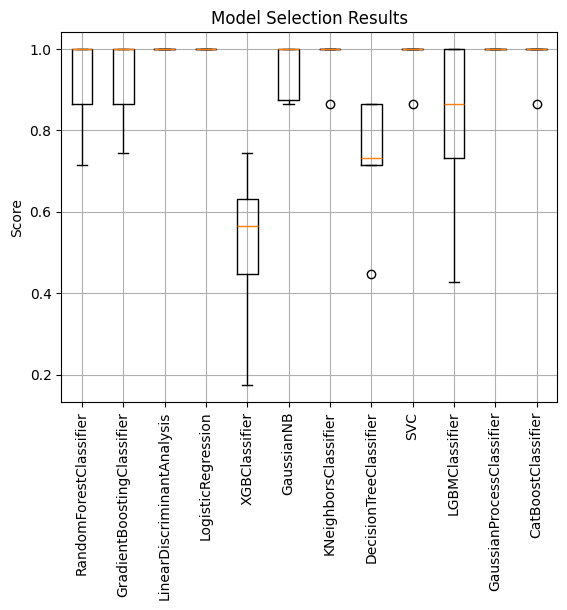

[I 2024-02-07 14:43:08,392] A new study created in memory with name: no-name-bb776efb-1c9f-42f6-97c9-f3ab3e305abd
[I 2024-02-07 14:43:08,408] Trial 0 finished with value: 1.0 and parameters: {'solver': 'lsqr', 'shrinkage': 0.49312269078346715, 'tol': 0.001}. Best is trial 0 with value: 1.0.
[I 2024-02-07 14:43:08,421] Trial 1 finished with value: 1.0 and parameters: {'solver': 'svd', 'store_covariance': False, 'tol': 0.001}. Best is trial 0 with value: 1.0.
[I 2024-02-07 14:43:08,438] Trial 2 finished with value: 1.0 and parameters: {'solver': 'eigen', 'shrinkage': 0.8352874801655523, 'tol': 0.001}. Best is trial 0 with value: 1.0.
[I 2024-02-07 14:43:08,453] Trial 3 finished with value: 1.0 and parameters: {'solver': 'lsqr', 'shrinkage': 0.14644860276255278, 'tol': 0.0001}. Best is trial 0 with value: 1.0.
[I 2024-02-07 14:43:08,469] Trial 4 finished with value: 1.0 and parameters: {'solver': 'eigen', 'shrinkage': 0.19498734951641072, 'tol': 0.001}. Best is trial 0 with value: 1.0.
[I

For the LinearDiscriminantAnalysis model: 
Best parameters: {'solver': 'lsqr', 'shrinkage': 0.49312269078346715, 'tol': 0.001}
Best matthews_corrcoef: 1.0


In [4]:
fitted_mod ,df= mlpipe.model_selection(optimizer='bayesian_search',n_trials=10,num_trials=1,score='matthews_corrcoef', train_best='bayesian_search',return_model=True,plot='box',scores_df=True)#,search_on=[CatBoostClassifier()])#, exclude=[XGBClassifier()],result=True)

In [10]:
print(df.Best_Params[0])
print(df.Scores[0])

[{'n_estimators': 107, 'criterion': 'gini', 'max_depth': 38, 'min_samples_leaf': 5, 'min_samples_split': 5, 'bootstrap': True}
 {'n_estimators': 119, 'criterion': 'gini', 'max_depth': 37, 'min_samples_leaf': 2, 'min_samples_split': 7, 'bootstrap': True}
 {'n_estimators': 79, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'bootstrap': True}
 {'n_estimators': 115, 'criterion': 'entropy', 'max_depth': 34, 'min_samples_leaf': 2, 'min_samples_split': 6, 'bootstrap': False}
 {'n_estimators': 52, 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 4, 'bootstrap': True}]
[1.         1.         0.71428571 0.8660254  1.        ]


In [36]:
# import pickle
# filename = 'fitted_10.sav'
# # # pickle.dump(fitted_mod, open(filename, 'wb'))
# fitted_mod = pickle.load(open(filename, 'rb'))

# dataloader
mlpipe = MLPipelines(estimator=model, param_grid={}, label=label, csv_dir=csv_dir)
# mlpipe._encode_labels()
mlpipe.normalize()
# mlpipe.feature_selection(method='mrmr', n_features=10, inner_method='chi2')


Label mapping: {0: 'Factor1:CASE', 1: 'Factor1:CONTROL'}


In [37]:
# fitted_mod = XGBClassifier(booster='gbtree').fit(mlpipe.X, mlpipe.y)
# fitted_mod = RandomForestClassifier().fit(mlpipe.X, mlpipe.y)
fitted_mod = LogisticRegression().fit(mlpipe.X, mlpipe.y)
# fitted_mod = DecisionTreeClassifier().fit(mlpipe.X, mlpipe.y)
# fitted_mod = GradientBoostingClassifier().fit(mlpipe.X, mlpipe.y)
# fitted_mod = LinearDiscriminantAnalysis().fit(mlpipe.X, mlpipe.y)
# fitted_mod = GaussianNB().fit(mlpipe.X, mlpipe.y)
# fitted_mod = GaussianProcessClassifier().fit(mlpipe.X, mlpipe.y)
# fitted_mod = SVC().fit(mlpipe.X, mlpipe.y)
# fitted_mod = CatBoostClassifier(verbose=0).fit(mlpipe.X, mlpipe.y)

In [38]:
fesel = FeaturesExplanation(best_estimator=fitted_mod, X=mlpipe.X, y=mlpipe.y, label_mapping=mlpipe.label_mapping)
fesel.calculate_shap_values(explainer_type='linear')


In [39]:
fesel.shap_values.shape

(71, 1430)

The shap values do not exist for the label 1. The following is the summary plot for all the labels.


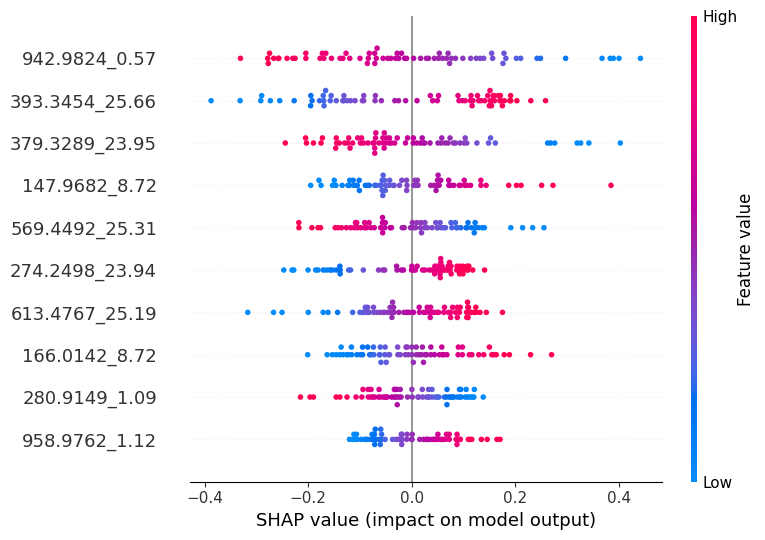

In [43]:
fesel.plot_shap_values(plot_type='summary',label=1)

In [ ]:
import shap

**χερατα**

In [44]:
from dash import Dash, dcc, html, Input, Output
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display
import ipywidgets as widgets

app = Dash(__name__)

app.layout = html.Div([
    html.H4("Visualization of PCA's explained variance"),
    dcc.Graph(id="graph"),
    html.P("Number of components:"),
    dcc.Slider(
        id='slider',
        min=2, max=5, value=3, step=1)
])

@app.callback(
    Output("graph", "figure"), 
    Input("slider", "value"))
def run_and_plot(n_components):
    try:
        pca = PCA(n_components=n_components)
        components = pca.fit_transform(fesel.X)

        var = pca.explained_variance_ratio_.sum() * 100
        labels = {i: f'PC{i+1}' for i in range(n_components)}

        fig = px.scatter_matrix(
            components,
            color=fesel.y,
            dimensions=range(n_components),
            labels=labels,
            title=f'Total Explained Variance: {var:.2f}%')
        fig.update_traces(diagonal_visible=False)
        return fig
    except Exception as e:
        return px.scatter_matrix(title=f'An error occurred: {e}')

app.run_server(debug=True)

In [45]:
def create_pca_dataframe(X, n_components):
    """
    Performs PCA on the given dataset X and returns a DataFrame with the principal components.

    Parameters:
    - X: array-like, shape (n_samples, n_features)
        The input data to perform PCA on.
    - n_components: int
        The number of principal components to compute.

    Returns:
    - df_pca: pandas.DataFrame
        DataFrame containing the principal components.
    """
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(X)
    component_names = [f'PC{i+1}' for i in range(n_components)]
    df_pca = pd.DataFrame(components, columns=component_names)
    return df_pca

df_pca = create_pca_dataframe(fesel.X, 2)

# mean_shap_values = abs(fesel.shap_values.values).mean(axis=0)

# fig = make_subplots(rows=1, cols=2, subplot_titles=('PCA Plot', 'SHAP Values'),
#                     specs=[[{'type': 'scatter'}, {'type': 'bar'}]])

# scatter = go.Scatter(x=df_pca['PC1'], y=df_pca['PC2'], mode='markers', name='Data Points',
#                      marker=dict(color=fesel.y, colorscale='Viridis', showscale=True))

# bar = go.Bar(x=[f'Feature {i}' for i in range(len(mean_shap_values))], y=mean_shap_values)

# fig.add_trace(scatter, row=1, col=1)
# fig.add_trace(bar, row=1, col=2)

# fig.update_layout(showlegend=False, width=1000, height=500, clickmode='event+select')

# fig_widget = go.FigureWidget(fig)

# def update_shap_plot(trace, points, state):
#     if points.point_inds:
#         idx = points.point_inds[0]  
#         shap_values_point = fesel.shap_values.values[idx]  
#         with fig_widget.batch_update():
#             fig_widget.data[1].y = shap_values_point

# fig_widget.data[0].on_click(update_shap_plot)
# display(fig_widget)


FigureWidget({
    'data': [{'marker': {'color': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                                         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                                         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
                         'colorscale': [[0.0, '#440154'], [0.1111111111111111,
                                        '#482878'], [0.2222222222222222,
                                        '#3e4989'], [0.3333333333333333,
                                        '#31688e'], [0.4444444444444444,
                                        '#26828e'], [0.5555555555555556,
                                        '#1f9e89'], [0.6666666666666666,
                                        '#35b779'], [0.7777777777777778,
                                        '#6ece58'], [0.8888888888888888,
                                        '#b5de2b'], [1.0,

In [57]:
def create_interactive_pca_shap_plot(df_pca, X, components, image_size=(1000, 500),top_n_features=20):
    """
    Creates an interactive plot with PCA on one side and SHAP values on the other.

    Parameters:
    - df_pca: DataFrame containing PCA components.
    - X: The original dataset used for PCA and SHAP value calculation.
    - components: Tuple of indices for the PCA components to plot, e.g., (0, 1) for PC1 vs. PC2.
    - image_size: Tuple for the image size, default to (1000, 500).

    Returns:
    - A Plotly FigureWidget with interactive capabilities in a Jupyter environment.
    """
    pc_x, pc_y = f'PC{components[0]+1}', f'PC{components[1]+1}'
    
    mean_shap_values = abs(fesel.shap_values.values).mean(axis=0)
    top_indices = mean_shap_values.argsort()[-top_n_features:][::-1]  # Indices of top features
    top_mean_shap_values = mean_shap_values[top_indices]

    fig = make_subplots(rows=1, cols=2, subplot_titles=('PCA Plot', 'SHAP Values'),
                        specs=[[{'type': 'scatter'}, {'type': 'bar'}]],
                        horizontal_spacing=0.1)
    
    scatter = go.Scatter(x=df_pca[pc_x], y=df_pca[pc_y], mode='markers', name='Data Points',
                         marker=dict(color=fesel.y, colorscale='Viridis', showscale=True))
    fig.add_trace(scatter, row=1, col=1)

    bar = go.Bar(x=[f'Feature {i}' for i in top_indices], y=top_mean_shap_values)
    fig.add_trace(bar, row=1, col=2)

    fig.update_layout(showlegend=False, width=image_size[0], height=image_size[1], clickmode='event+select')

    # Convert to FigureWidget for interactivity in Jupyter
    fig_widget = go.FigureWidget(fig)

    # Define callback function for updates
    def update_shap_plot(trace, points, selector):
        if points.point_inds:
            idx = points.point_inds[0]  
            shap_values_point = fesel.shap_values.values[idx][top_indices]  
            with fig_widget.batch_update():
                fig_widget.data[1].y = shap_values_point

    fig_widget.data[0].on_click(update_shap_plot)

    return fig_widget

In [59]:
create_interactive_pca_shap_plot(df_pca, fesel.X, (0, 1), image_size=(1000, 500),top_n_features=30)

FigureWidget({
    'data': [{'marker': {'color': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                                         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                                         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
                         'colorscale': [[0.0, '#440154'], [0.1111111111111111,
                                        '#482878'], [0.2222222222222222,
                                        '#3e4989'], [0.3333333333333333,
                                        '#31688e'], [0.4444444444444444,
                                        '#26828e'], [0.5555555555555556,
                                        '#1f9e89'], [0.6666666666666666,
                                        '#35b779'], [0.7777777777777778,
                                        '#6ece58'], [0.8888888888888888,
                                        '#b5de2b'], [1.0,